## <font color='green'>Setup 1</font>: Load Libraries

In [1]:
import sys
root_dir = "../"
sys.path.append(root_dir)

from test_bad_word import *
from utility import *

import time
import numpy as np
import pandas as pd
#pd.options.display.max_columns = None
#pd.options.display.mpl_style = 'default'
import tensorflow as tf
import seaborn as sns

import re
import os
import sys
import random
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import sparse

from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
    
stemmer = SnowballStemmer('english')

## <font color='green'>Setup 2</font>: Load Datasets

In [2]:
train_sentence = np.load('Sentence-Level-Preprocessed-Data/train_sentence.npy')
train_length = np.load('Sentence-Level-Preprocessed-Data/train_length.npy')
train_label = np.load('Sentence-Level-Preprocessed-Data/train_label.npy')

test_sentence = np.load('Sentence-Level-Preprocessed-Data/test_sentence.npy')
test_length = np.load('Sentence-Level-Preprocessed-Data/test_length.npy')
test_label = np.load('Sentence-Level-Preprocessed-Data/test_label.npy')

ver_sentence = np.load('Sentence-Level-Preprocessed-Data/val_sentence.npy')
ver_length = np.load('Sentence-Level-Preprocessed-Data/val_length.npy')
ver_label = np.load('Sentence-Level-Preprocessed-Data/val_label.npy')

embedding = np.load('Sentence-Level-Preprocessed-Data/embedding.npy')

In [3]:
slice_index = 200

train_sentence = train_sentence[:,:slice_index]
test_sentence = test_sentence[:,:slice_index]
ver_sentence = ver_sentence[:,:slice_index]

train_length = np.array([i if i <= slice_index else slice_index for i in train_length])
test_length = np.array([i if i <= slice_index else slice_index for i in test_length])
ver_length = np.array([i if i <= slice_index else slice_index for i in ver_length])

In [4]:
sentence  = np.concatenate((train_sentence, test_sentence))
length = np.concatenate((train_length, test_length))
label = np.concatenate((train_label, test_label))


np.random.seed(10)
val_list = np.random.choice(range(len(sentence)), round(len(sentence)/10))
train_list = list(set(range(len(sentence))).difference(set(val_list))) 

In [5]:
train_sentence = sentence[train_list]
train_length = length[train_list]
train_label = label[train_list]

val_sentence = sentence[val_list]
val_length = length[val_list]
val_label = label[val_list]

test_sentence = ver_sentence
test_length = ver_length
test_label = ver_label

## <font color='green'>Setup 3</font>: Model

In [6]:
def attention(inputs, max_len, attention_size, time_major=False):
  
    if isinstance(inputs, tuple):
        # In case of Bi-RNN, concatenate the forward and the backward RNN outputs.
        inputs = tf.concat(inputs, 2)

    if time_major:
        # (T,B,D) => (B,T,D)
        inputs = tf.array_ops.transpose(inputs, [1, 0, 2])

    inputs_shape = inputs.shape
    sequence_length = max_len  # the length of sequences processed in the antecedent RNN layer
    hidden_size = inputs_shape[2].value  # hidden size of the RNN layer

    # Attention mechanism
    W_omega = tf.Variable(tf.random_normal([hidden_size, attention_size], stddev=0.2, seed =1))
    b_omega = tf.Variable(tf.random_normal([attention_size], stddev=0.1, seed =1))
    u_omega = tf.Variable(tf.random_normal([attention_size], stddev=0.2, seed =1))

    v = tf.tanh(tf.matmul(tf.reshape(inputs, [-1, hidden_size]), W_omega) + tf.reshape(b_omega, [1, -1]))
    vu = tf.matmul(v, tf.reshape(u_omega, [-1, 1]))
    exps = tf.reshape(tf.exp(vu), [-1, sequence_length])
    alphas = exps / tf.reshape(tf.reduce_sum(exps, 1), [-1, 1])

    # Output of Bi-RNN is reduced with attention vector
    output = tf.reduce_sum(inputs * tf.reshape(alphas, [-1, sequence_length, 1]), 1)

    return output


def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))


def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]

In [7]:
vocab_size = embedding.shape[0]
word2vec_size = embedding.shape[1]
max_len = train_sentence.shape[1]

batch_size = 200
RNN_hidden_size = 100
fully_connected_hidden_size = 512
multi_layer_size = 1
target_size = 2

In [8]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
sess = tf.InteractiveSession()

sentence = tf.placeholder(tf.int32, [None, None], "sentence")               
sentence_length = tf.placeholder(tf.int32, [None], "sentence_length")        
label = tf.placeholder(tf.int64, [None], "label")                         
keep_prob = tf.placeholder(tf.float32, (),  'keep_prob')
max_len = tf.placeholder(tf.int32, (),  'max_len')

initializer = tf.random_uniform_initializer(-0.5, 0.5)
with tf.device('/cpu:0'):
    embeddings = tf.get_variable("embeddings", [vocab_size, word2vec_size], initializer=initializer, trainable= True)
    embeddings = embeddings.assign(embedding)

sentence_embedded = tf.nn.embedding_lookup(embeddings, sentence)  

### ------------------------------------------------------------------------------------------------------- ### 
### ---------------------------------------- sentence encoders -------------------------------------------  ###
### ------------------------------------------------------------------------------------------------------- ### 

sentence_cell = tf.contrib.rnn.LSTMCell(RNN_hidden_size) 
sentence_all, sentence_final_state  = tf.nn.dynamic_rnn(sentence_cell,\
                                        sentence_embedded, sequence_length = sentence_length, dtype=tf.float32)        
   
#sentence_vector = tf.nn.relu(sentence_final_state.h)
h = tf.layers.batch_normalization(sentence_final_state.h)
h = tf.nn.dropout(h, keep_prob)

### ------------------------------------------------------------------------------------------------------- ### 
### ---------------------------------------- loss & prediction -------------------------------------------  ###
### ------------------------------------------------------------------------------------------------------- ###     

for i in range(multi_layer_size):
    h = tf.contrib.layers.linear(h, 100, activation_fn = tf.nn.relu)
    #h = tf.layers.batch_normalization(h)

logits = tf.contrib.layers.linear(h, target_size)

probability = tf.nn.softmax(logits)
predict = tf.argmax(probability, axis=1)

#L2 = tf.add_n([ tf.nn.l2_loss(v) for v in tf.trainable_variables()]) 
loss = tf.reduce_sum(tf.losses.sparse_softmax_cross_entropy(logits = logits, labels = label, weights = label*2 + 1 ))
opt_op = tf.train.AdamOptimizer(0.001).minimize(loss)

saver = tf.train.Saver()
print('graph created')

graph created


In [26]:
BATCH_SIZE = 100
split_num = 5
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    n = train_sentence.shape[0]

    part_train_sentence = train_sentence[:500]
    part_train_length = train_length[:500]
    part_train_label = train_label[:500]
    train_feed_dict = {sentence: part_train_sentence, sentence_length: part_train_length, label: part_train_label, keep_prob: 1, \
                       max_len: train_sentence.shape[1]}
    
    val_sentence_splited = list(split(val_sentence, split_num))
    val_label_splited = list(split(val_label, split_num))
    val_length_splited = list(split(val_length, split_num))    

    for epoch in range(25):
        print('----- Epoch', epoch + 1, '-----')
        total_loss = 0
        t_0 = time.time()
        
        train_index = list(range(len(train_sentence)))
        random.shuffle(train_index)
        random_train_index = list(chunks(train_index, n // BATCH_SIZE))
        
        for i in range(n // BATCH_SIZE):
            inst_train_sentence = train_sentence[random_train_index[i]]
            inst_train_label = train_label[random_train_index[i]]
            inst_train_length = train_length[random_train_index[i]]

            feed_dict = {sentence: inst_train_sentence, sentence_length: inst_train_length, label:inst_train_label, keep_prob: 0.75,\
                    max_len: train_sentence.shape[1]}
            _, current_loss = sess.run([opt_op, loss], feed_dict=feed_dict)
            total_loss += current_loss

        print(' Train loss:', total_loss / n, 'Time:', round((time.time()-t_0)/60,2),'minute') 
        save_path = saver.save(sess, "./rnn_baseline_model_%s.ckpt" % (epoch+1))
        
        train_predicted, train_probability = sess.run([predict, probability], feed_dict=train_feed_dict)
        train_f1 = f1_score(train_label[:500], train_predicted)
        train_auc = roc_auc_score(train_label[:500], np.array(train_probability)[:,1])
        print(' Train F1:', train_f1,' Train AUC:', train_auc)
        
        val_predicted = []
        val_probability = []
        for i in range(split_num):
            val_feed_dict = {sentence: val_sentence_splited[i], label: val_label_splited[i], sentence_length: val_length_splited[i], \
                              keep_prob: 1, max_len: val_sentence.shape[1]} 
            val_current_predicted, val_current_probability = sess.run([predict,probability], feed_dict=val_feed_dict)
            val_predicted = val_predicted + list(val_current_predicted)
            val_probability = val_probability + list(val_current_probability)

        val_f1 = f1_score(val_label, val_predicted)
        val_auc = roc_auc_score(val_label, np.array(val_probability)[:,1])
        print(' Dev F1:', val_f1,' Dev AUC:', val_auc)

----- Epoch 1 -----
 Train loss: 0.00867553151294 Time: 0.35 minute
 Train F1: 0.641833810888  Train AUC: 0.882906036482
 Dev F1: 0.643326039387  Dev AUC: 0.875235271974
----- Epoch 2 -----
 Train loss: 0.00713571501558 Time: 0.33 minute
 Train F1: 0.659217877095  Train AUC: 0.902818696588
 Dev F1: 0.681614349776  Dev AUC: 0.892692452475
----- Epoch 3 -----
 Train loss: 0.00632639596326 Time: 0.29 minute
 Train F1: 0.701219512195  Train AUC: 0.909337846591
 Dev F1: 0.686774941995  Dev AUC: 0.9025738754
----- Epoch 4 -----
 Train loss: 0.0063534771886 Time: 0.27 minute
 Train F1: 0.703812316716  Train AUC: 0.918385256692
 Dev F1: 0.692840646651  Dev AUC: 0.902762092979
----- Epoch 5 -----
 Train loss: 0.00583690945684 Time: 0.3 minute
 Train F1: 0.678062678063  Train AUC: 0.919659834096
 Dev F1: 0.687640449438  Dev AUC: 0.898691887822
----- Epoch 6 -----
 Train loss: 0.00593576674793 Time: 0.33 minute
 Train F1: 0.75  Train AUC: 0.931005662467
 Dev F1: 0.700729927007  Dev AUC: 0.9096555

KeyboardInterrupt: 

In [14]:
BATCH_SIZE = 100
split_num = 5
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "rnn_baseline_model_16.ckpt")
    n = train_sentence.shape[0]

    val_sentence_splited = list(split(val_sentence, split_num))
    val_label_splited = list(split(val_label, split_num))
    val_length_splited = list(split(val_length, split_num))    

    val_predicted = []
    val_probability = []
    for i in range(split_num):
        val_feed_dict = {sentence: val_sentence_splited[i], label: val_label_splited[i], sentence_length: val_length_splited[i], \
                          keep_prob: 1, max_len: val_sentence.shape[1]} 
        val_current_predicted, val_current_probability = sess.run([predict,probability], feed_dict=val_feed_dict)
        val_predicted = val_predicted + list(val_current_predicted)
        val_probability = val_probability + list(val_current_probability)

    val_f1 = f1_score(val_label, val_predicted)
    val_auc = roc_auc_score(val_label, np.array(val_probability)[:,1])
    print(' Dev F1:', val_f1,' Dev AUC:', val_auc)

INFO:tensorflow:Restoring parameters from rnn_baseline_model_16.ckpt
 Dev F1: 0.755208333333  Dev AUC: 0.921513269339


In [15]:
BATCH_SIZE = 100
split_num = 5
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "rnn_baseline_model_16.ckpt")
    n = train_sentence.shape[0]

    test_sentence_splited = list(split(test_sentence, split_num))
    test_label_splited = list(split(test_label, split_num))
    test_length_splited = list(split(test_length, split_num))    

    test_predicted = []
    test_probability = []
    for i in range(split_num):
        test_feed_dict = {sentence: test_sentence_splited[i], label: test_label_splited[i], sentence_length: test_length_splited[i], \
                          keep_prob: 1, max_len: test_sentence.shape[1]} 
        test_current_predicted, test_current_probability = sess.run([predict,probability], feed_dict=test_feed_dict)
        test_predicted = test_predicted + list(test_current_predicted)
        test_probability = test_probability + list(test_current_probability)

    test_f1 = f1_score(test_label, test_predicted)
    test_auc = roc_auc_score(test_label, np.array(test_probability)[:,1])
    print(' Dev F1:', test_f1,' Dev AUC:', test_auc)

INFO:tensorflow:Restoring parameters from rnn_baseline_model_16.ckpt
 Dev F1: 0.764705882353  Dev AUC: 0.839627202794


[[954 204]
 [284 793]]


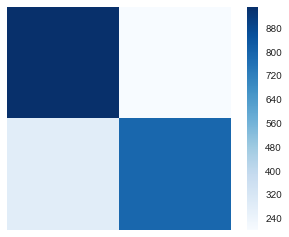

In [16]:
def plot_confusion_matrix_dict(matrix,rotation=45, outside_label=""):
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(0)
    plt.xticks(tick_marks, [0,1], rotation=rotation)
    plt.yticks(tick_marks, [0,1])
    
cm=confusion_matrix(test_label, test_predicted)
print(cm)
plot_confusion_matrix_dict(cm)

In [18]:
np.save('rnn_baseline_pred_test_prob', np.array(test_probability)[:,1])
np.save('rnn_baseline_pred_test', test_predicted)
np.save('rnn_baseline_pred_val_prob', np.array(val_probability)[:,1])
np.save('rnn_baseline_pred_val', val_predicted)
np.save('val_real',val_label)
np.save('test_real',test_label)